In [1]:
import os
import re
import numpy as np

from robosuite.models.objects import MujocoXMLObject
from robosuite.utils.mjcf_utils import xml_path_completion

from libero.libero.envs.base_object import register_object

import pathlib

from libero.libero.envs.base_object import (
    register_visual_change_object,
    register_object,
)
from libero.libero.utils.mu_utils import register_mu, InitialSceneTemplates
from libero.libero.utils.task_generation_utils import register_task_info, get_task_info, generate_bddl_from_task_info


[robosuite WARNING] No private macro file found! (__init__.py:7)
[robosuite WARNING] It is recommended to use a private macro file (__init__.py:8)
[robosuite WARNING] To setup, run: python /home/ljr/.conda/envs/libero/lib/python3.8/site-packages/robosuite/scripts/setup_macros.py (__init__.py:9)


## Define your own objects
You may want to include more object meshes of yours in the procedural generation pipeline. One option is to include your assets and define your object directly inside the LIBERO codebase. But this can make the whole thing messy. 

Alternatively, you can define the objects inside your custom project repo folder, and define the object classes accordingly. Note that you need to import your defined object classes whenever you run your own stuff. Libero codebase cannot automatically import those that are defined outside its repo.

In the next, we provide an example, assuming you have object meses defined in `custom_assets`. In this example, we assume the generated pddl file will be saved in `custom_pddl`.

In [2]:

class CustomObjects(MujocoXMLObject):
    def __init__(self, custom_path, name, obj_name, joints=[dict(type="free", damping="0.0005")]):
        # make sure custom path is an absolute path
        assert(os.path.isabs(custom_path)), "Custom path must be an absolute path"
        # make sure the custom path is also an xml file
        assert(custom_path.endswith(".xml")), "Custom path must be an xml file"
        super().__init__(
            custom_path,
            name=name,
            joints=joints,
            obj_type="all",
            duplicate_collision_geoms=False,
        )
        self.category_name = "_".join(
            re.sub(r"([A-Z])", r" \1", self.__class__.__name__).split()
        ).lower()
        self.object_properties = {"vis_site_names": {}}

@register_object
class LiberoMug(CustomObjects):
    def __init__(self,
                 name="libero_mug",
                 obj_name="libero_mug",
                 ):
        super().__init__(
            custom_path=os.path.abspath(os.path.join(
                "./", "custom_assets", "libero_mug", "libero_mug.xml"
            )),
            name=name,
            obj_name=obj_name,
        )

        self.rotation = {
            "x": (-np.pi/2, -np.pi/2),
            "y": (-np.pi, -np.pi),
            "z": (np.pi, np.pi),
        }
        self.rotation_axis = None

@register_object
class LiberoMugYellow(CustomObjects):
    def __init__(self,
                 name="libero_mug",
                 obj_name="libero_mug",
                 ):
        super().__init__(
            custom_path=os.path.abspath(os.path.join(
                "./", "custom_assets", "libero_mug_yellow", "libero_mug_yellow.xml"
            )),
            name=name,
            obj_name=obj_name,
        )

        self.rotation = {
            "x": (-np.pi/2, -np.pi/2),
            "y": (-np.pi, -np.pi),
            "z": (np.pi, np.pi),
        }
        self.rotation_axis = None


### Define the scene
Now we define the scene to load the previously defined objects. For more information about the scene genration, please look at `procedural_creation_walkthrough.ipynb`. 

In [3]:
import re
from libero.libero.envs import objects
from libero.libero.utils.bddl_generation_utils import *
from libero.libero.envs.objects import OBJECTS_DICT
from libero.libero.utils.object_utils import get_affordance_regions

from libero.libero.utils.mu_utils import register_mu, InitialSceneTemplates

@register_mu(scene_type="kitchen")
class KitchenDemoScene(InitialSceneTemplates):
    def __init__(self):

        fixture_num_info = {
            "kitchen_table": 1,
            "wooden_cabinet": 1,
        }

        object_num_info = {
            "libero_mug": 1,
            "libero_mug_yellow": 1,
        }

        super().__init__(
            workspace_name="kitchen_table",
            fixture_num_info=fixture_num_info,
            object_num_info=object_num_info,
        )

    def define_regions(self):
        self.regions.update(
            self.get_region_dict(
                region_centroid_xy=[0.0, -0.30],
                region_name="wooden_cabinet_init_region",
                target_name=self.workspace_name,
                region_half_len=0.01,
                yaw_rotation=(np.pi, np.pi),
            )
        )

        self.regions.update(
            self.get_region_dict(
                region_centroid_xy=[0.0, 0.0],
                region_name="libero_mug_init_region",
                target_name=self.workspace_name,
                region_half_len=0.025,
            )
        )

        self.regions.update(
            self.get_region_dict(
                region_centroid_xy=[-0.1, 0.15],
                region_name="libero_mug_yellow_init_region",
                target_name=self.workspace_name,
                region_half_len=0.025,
            )
        )
        self.xy_region_kwargs_list = get_xy_region_kwargs_list_from_regions_info(
            self.regions
        )

    @property
    def init_states(self):
        states = [
            ("On", "libero_mug_1", "kitchen_table_libero_mug_init_region"),
            ("On", "libero_mug_yellow_1", "kitchen_table_libero_mug_yellow_init_region"),
            ("On", "wooden_cabinet_1", "kitchen_table_wooden_cabinet_init_region"),
        ]
        return states

Succefully generated: 1
Encountered some failures:  []
(define (problem LIBERO_Kitchen_Tabletop_Manipulation)
  (:domain robosuite)
  (:language libero demo behaviors)
    (:regions
      (wooden_cabinet_init_region
          (:target kitchen_table)
          (:ranges (
              (-0.01 -0.31 0.01 -0.29)
            )
          )
          (:yaw_rotation (
              (3.141592653589793 3.141592653589793)
            )
          )
      )
      (libero_mug_init_region
          (:target kitchen_table)
          (:ranges (
              (-0.025 -0.025 0.025 0.025)
            )
          )
          (:yaw_rotation (
              (0.0 0.0)
            )
          )
      )
      (libero_mug_yellow_init_region
          (:target kitchen_table)
          (:ranges (
              (-0.125 0.125 -0.07500000000000001 0.175)
            )
          )
          (:yaw_rotation (
              (0.0 0.0)
            )
          )
      )
      (top_side
          (:target wooden_cabinet_1)
 

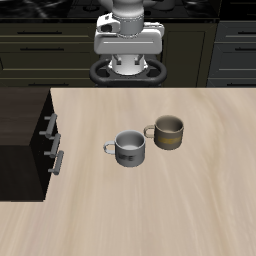

In [4]:
scene_name = "kitchen_demo_scene"
language = "libero demo behaviors"
register_task_info(language,
                   scene_name=scene_name,
                   objects_of_interest=[],
                   goal_states=[
                       ("Open", "wooden_cabinet_1_top_region"),
                       ("In", "libero_mug_yellow_1", "wooden_cabinet_1_top_region"),
                       ],
)

YOUR_BDDL_FILE_PATH = "./custom_pddl"
bddl_file_names, failures = generate_bddl_from_task_info(folder=YOUR_BDDL_FILE_PATH)

print("Encountered some failures: ", failures)

with open(bddl_file_names[0], "r") as f:
    print(f.read())

from libero.libero.envs import OffScreenRenderEnv
from IPython.display import display
from PIL import Image


env_args = {
    "bddl_file_name": bddl_file_names[0],
    "camera_heights": 256,
    "camera_widths": 256
}

env = OffScreenRenderEnv(**env_args)
obs = env.reset()
display(Image.fromarray(obs["agentview_image"][::-1]))